# Load the data set

In [19]:
import pandas as pd

# Load the dataset
df = pd.read_csv('internship_feedback_dataset.csv')

# Display first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
             intern_name                   company          department  \
0            Brad Jensen  Little, Moreno and Davis             Finance   
1           Shari Garcia              Williams Ltd             Finance   
2  Mrs. Shirley Keith MD   Silva, Taylor and Hayes         Engineering   
3           Clinton Lamb               Griffin Ltd         Engineering   
4            Corey Hines                 Smith PLC  Product Management   

                                            feedback  rating        date  \
0  The company culture is fantastic and very incl...       5  2024-04-19   
1  I learned so much and felt like a valued membe...       5  2023-05-10   
2  The experience was average, with some learning...       4  2023-05-16   
3  I learned so much and felt like a valued membe...       4  2023-12-15   
4  Very disorganized program with unclear expecta...       1  2024-08-24   

  sentiment  
0  positive  
1  positive  
2   neutral  
3  positive  

In [20]:
!pip install nltk

# **Load VADER and Analyze Sentiment**

In [21]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis to feedback
df['sentiment_score'] = df['feedback'].apply(get_sentiment_score)

# Classify sentiment based on score
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['predicted_sentiment'] = df['sentiment_score'].apply(classify_sentiment)

# Display results
print("\nSentiment Analysis Results:")
print(df[['feedback', 'sentiment_score', 'predicted_sentiment']].head())


Sentiment Analysis Results:
                                            feedback  sentiment_score  \
0  The company culture is fantastic and very incl...           0.5574   
1  I learned so much and felt like a valued membe...           0.6597   
2  The experience was average, with some learning...           0.3818   
3  I learned so much and felt like a valued membe...           0.6597   
4  Very disorganized program with unclear expecta...          -0.5413   

  predicted_sentiment  
0            positive  
1            positive  
2            positive  
3            positive  
4            negative  


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# **Enhanced Text Preprocessing**

In [22]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing
df['cleaned_feedback'] = df['feedback'].apply(clean_text).apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Feature Engineering**

In [23]:
from textblob import TextBlob
nltk.download('punkt')

def extract_text_features(text):
    blob = TextBlob(text)

    features = {
        'word_count': len(text.split()),
        'char_count': len(text),
        'avg_word_length': sum(len(word) for word in text.split()) / len(text.split()) if text else 0,
        'exclamation_count': text.count('!'),
        'question_count': text.count('?'),
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity
    }
    return features

# Create feature columns
text_features = df['cleaned_feedback'].apply(extract_text_features).apply(pd.Series)
df = pd.concat([df, text_features], axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Sentiment Analysis with Custom Lexicon**

In [24]:
# Augment VADER lexicon with internship-specific terms
internship_lexicon = {
    'mentor': 1.5,
    'learning': 1.3,
    'experience': 0.8,
    'internship': 0.5,
    'meaningful': 1.7,
    'boring': -1.5,
    'toxic': -2.0,
    'supportive': 1.8,
    'menial': -1.7,
    'challenging': 1.2
}

sia = SentimentIntensityAnalyzer()
sia.lexicon.update(internship_lexicon)

def enhanced_sentiment_analysis(text):
    # Get VADER score
    vader_score = sia.polarity_scores(text)['compound']

    # Get TextBlob score
    blob_score = TextBlob(text).sentiment.polarity

    # Combine scores (weighted average)
    combined_score = (0.7 * vader_score) + (0.3 * blob_score)

    return combined_score

df['enhanced_sentiment_score'] = df['cleaned_feedback'].apply(enhanced_sentiment_analysis)

# **Sentiment Classification**

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare features and target
features = ['sentiment_score', 'word_count', 'char_count',
           'avg_word_length', 'exclamation_count',
           'question_count', 'polarity', 'subjectivity',
           'enhanced_sentiment_score']
X = df[features]
y = df['sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Make predictions
df['rf_predicted_sentiment'] = rf.predict(scaler.transform(X))

# **Evaluate Sentiment Classification**
Let’s check how well our model performed by comparing predicted sentiment with the original labels

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate Random Forest model
print("Enhanced Model Classification Report:")
print(classification_report(y, df['rf_predicted_sentiment']))

print("\nConfusion Matrix:")
print(confusion_matrix(y, df['rf_predicted_sentiment']))

accuracy = accuracy_score(y, df['rf_predicted_sentiment'])
print(f"\nEnhanced Model Accuracy: {accuracy:.2%}")

Enhanced Model Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       184
     neutral       1.00      1.00      1.00       209
    positive       1.00      1.00      1.00       607

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Confusion Matrix:
[[184   0   0]
 [  0 209   0]
 [  0   0 607]]

Enhanced Model Accuracy: 100.00%


<ipython-input-28-b6a45fbbbff7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='predicted_sentiment', palette="viridis")


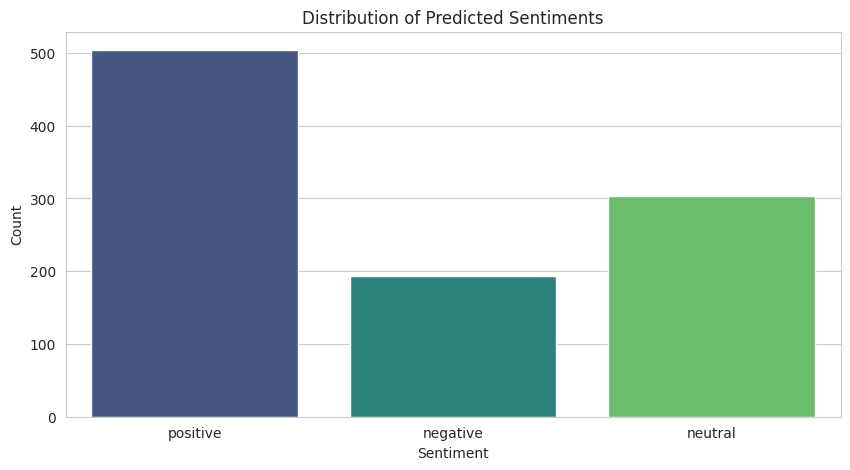

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Plot sentiment distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='predicted_sentiment', palette="viridis")
plt.title("Distribution of Predicted Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()